In [29]:
from qiskit import *
import numpy as np

from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from scipy.optimize import minimize

provider=IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-02 17:36:06,810: Credentials are already in use. The existing account in the session will be replaced.


In [30]:
def QAOA_Vertex_Cover(connections,gamma,beta):
    n=max(map(max, connections))+1
    qc=QuantumCircuit(n+1,n)


    qc.x(n)
    qc.h(range(n))
    
    
    qc.barrier()
    for i in connections:
        qc.cp(-1*gamma,i,n)
        qc.mcp(gamma,i,n)

        
    qc.barrier()


    for i in range(n):
        qc.x(i)
        qc.cp(-1*gamma,i,n)
        qc.x(i)


    qc.barrier()


    qc.rx(2*beta, range(n))


    qc.measure(range(n),range(n))

    return qc




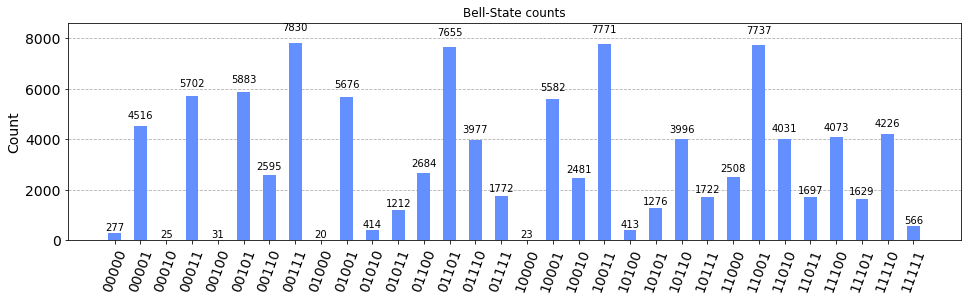

In [36]:
connections=[[0,1],[0,2],[0,3],[0,4],[1,3],[2,4]]
#gamma=[0,2pi], beta=[0,pi], gamma1<gamma2

gamma=np.pi*7/4
beta=np.pi*3.5/4
qc=QAOA_Vertex_Cover(connections,gamma,beta)

qc.draw()

simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
#result = simulator.run(circ,shots=100000).result()
#counts = result.get_counts(circ)
counts = simulator.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

In [40]:
class graph:
    def __init__(self, _graph=None):
        if _graph is None:
            _graph = {}
        self._graph = _graph
      
    def getVertices(self):
        return list(self._graph.keys())
    
    def printVertices(self):
        print(self.getVertices())
    
    def getEdges(self):
        edgename = []
        for vrtx in self._graph:
            for nxtvrtx in self._graph[vrtx]:
                if {nxtvrtx, vrtx} not in edgename:
                    edgename.append({vrtx, nxtvrtx})
        ret_list = []
        for i in range(len(edgename)):
            ret_list.append([])
            for j in edgename[i]:
                ret_list[i].append(j)
        return ret_list
    
    def printEdges(self):
        print(self.getEdges())
        
    def getGraph(self):
        return self._graph
    
    def make_graph_from_connections(self, connections):
        vertexs = []
        graph_dict = {}
        for edge_list in connections:
            for vertex in edge_list:
                if vertex not in vertexs:
                    vertexs.append(vertex)
                    
        for vertex in vertexs:
            graph_dict[vertex] = []
            
        for edge_list in connections:
            if edge_list[1] not in graph_dict[edge_list[0]]:
                graph_dict[edge_list[0]].append(edge_list[1])
                
            if edge_list[0] not in graph_dict[edge_list[1]]:
                graph_dict[edge_list[1]].append(edge_list[0])
                
        self._graph = graph_dict
        
    def printGraph(self):
        print(self._graph)
          
    

In [21]:
g = graph()
g.make_graph_from_connections(connections)
g.printEdges()
g.printVertices()
g.printGraph()

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 3], [2, 4]]
[0, 1, 2, 3, 4]
{0: [1, 2, 3, 4], 1: [0, 3], 2: [0, 4], 3: [0, 1], 4: [0, 2]}


In [77]:
def mvc_obj(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '1':
            obj1 += 1
    
    connections = graph.getEdges()
    for vtx in connections:
        obj2 += (1 - int(bitstring[vtx[0]]))*(1 - int(bitstring[vtx[0]]))
        
    return obj1 + obj2

def mvc_obj2(bitstring, graph):
    obj1 = 0
    obj2 = 0
    
    for i in range(len(bitstring)):
        if bitstring[i] == '0':
            obj1 -= 1
    
    connections = graph.getEdges()
    for vtx in connections:
        if bitstring[vtx[0]] == '1' or bitstring[vtx[1]] == '1':
            obj2 -= 1
        
    return obj1 + (obj2*1.2)

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count

def compute_expectation2(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = mvc_obj2(bitstring[::-1], graph)
        avg += obj*count
        sum_count += count
    
    return avg/sum_count

def get_expectation(graph, shots=10000):
    simulator = Aer.get_backend('aer_simulator')
    simulator.shots = shots
    connections = graph.getEdges()        

    def execute_circ(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, simulator)
        counts = simulator.run(circ,shots).result().get_counts()
        return compute_expectation(counts, graph)
    
    return execute_circ

def get_expectation2(graph, shots=100000):
    simulator = Aer.get_backend('aer_simulator')
    simulator.shots = shots
    connections = graph.getEdges()
            
    def execute_circ2(theta):
        
        qc = QAOA_Vertex_Cover(connections,theta[0],theta[1])
        circ = transpile(qc, simulator)
        counts = simulator.run(circ,shots).result().get_counts()
        return compute_expectation2(counts, graph)
    
    return execute_circ2
    

In [84]:
test = mvc_obj("11100", g)
print(test)

exp = compute_expectation(counts, g)
print(exp)

exp2 = compute_expectation2(counts, g)
print(exp2)

3
5.56726
-8.237506


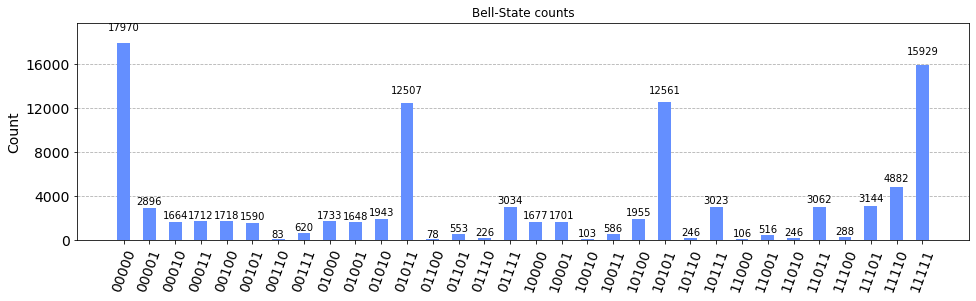

In [90]:
gamma=5
beta=2
theta = [gamma, beta]

qc=QAOA_Vertex_Cover(connections,gamma,beta)

simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
counts = simulator.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

Gamma: 5.491516187787636 ,Beta: 2.7336428056691444


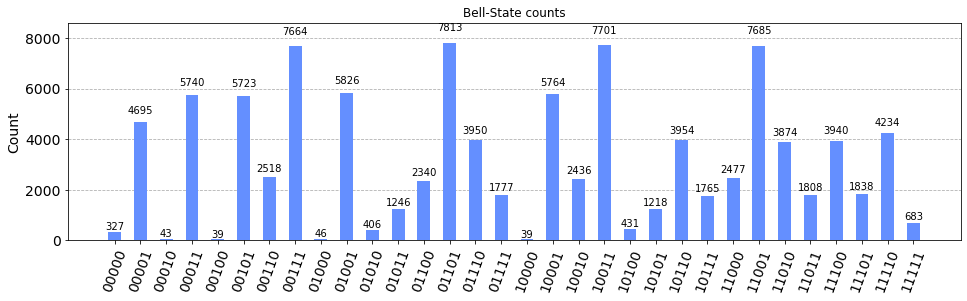

In [91]:
gamma=np.pi*7/4
beta=np.pi*3.5/4
theta = [gamma, beta]
expectation = get_expectation2(g)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma:", res.x[0], ",Beta:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
counts = simulator.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))

Gamma: -0.8344415328000837 ,Beta: -3.4826507091038637


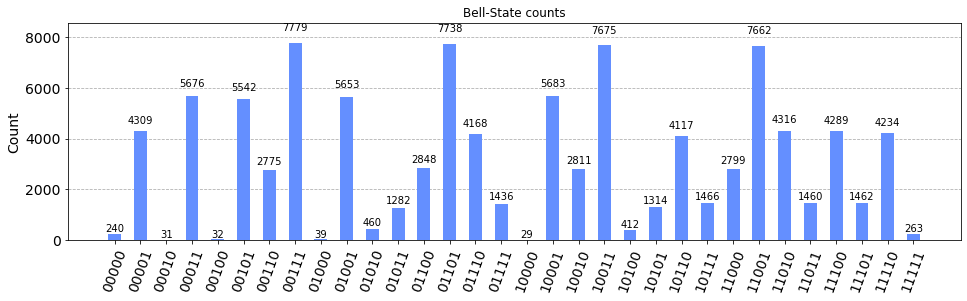

In [92]:
gamma=0
beta=0
theta = [gamma, beta]
expectation = get_expectation2(g)

res = minimize(expectation, theta, method='COBYLA')
print("Gamma:", res.x[0], ",Beta:", res.x[1])

qc=QAOA_Vertex_Cover(connections,res.x[0],res.x[1])

simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
counts = simulator.run(circ,shots=100000).result().get_counts()
plot_histogram(counts, title='Bell-State counts',figsize=(16,4))